In [ ]:
#################################################CODE FOR POST-MD SIMULATION ANALYSIS OF CONTACTS, DISTANCES AND H-BONDS###########################################
#Code based off of (https://userguide.mdanalysis.org/stable/examples/analysis/distances_and_contacts/distances_between_selections.html & https://userguide.mdanalysis.org/stable/examples/analysis/distances_and_contacts/contacts_within_cutoff.html) framework and chatgpt modifications for distance map, contacts and persistence of contacts, with CHATGPT modifications for intervals
#For H-bonds, the analysis is based off of: https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/hydrogenbonds.html and some chatgpt refinement
#Examples of the plots generated with this post Molecular Dynamics simulation are left intentionally to show as an example

In [ ]:
# MIT License
# Copyright (c) 2025 Rodolfo Adrian Arriaga Rivera
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction.
# See the LICENSE file for full license text.

In [ ]:
#Import necessary dependencies and the matplotlib inline to plot, also changing directory and printing it
import MDAnalysis as mda
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from MDAnalysis.analysis import contacts
os.chdir('path/to/working/directory')
print(os.getcwd())

/Volumes/ADATA HV 30/ifit5/ppp-mg


In [108]:
#Importing other utilities from MDAnalysis tests (for contacts plot)
from MDAnalysis.tests.datafiles import PDB_small
from MDAnalysis.analysis import distances

In [ ]:
#Defining the universe, the protein and ligand groups, also printing the length of the protein and the ligand
u = mda.Universe(".tpr", ".xtc") #.xtc should be centered and no PBC
protein = u.select_atoms("protein") #select the protein's atoms
ligand = u.select_atoms("resname PPP")  # Select the ligand's atoms

#Checking how many residues and atoms the protein and ligand have
n_protein = len(protein.residues)
m_ligand = len(ligand)
print('Protein has {} residues and ligand has {} atoms'.format(n_protein, m_ligand))

Protein has 482 residues and ligand has 80 atoms


In [111]:
#Creating and array of distances to plot and printing the size of it
dist_arr = distances.distance_array(protein.positions, ligand.positions, box=u.dimensions)

#Checking the array (should be protein and ligand sizes in # of positions of each atom)
dist_arr.shape

(7862, 80)

In [112]:
# Checking protein and ligand com's for proximity (should be relatively proximal to each other)
print("Protein center of mass:", protein.center_of_mass())
print("Ligand center of mass:", ligand.center_of_mass())

Protein center of mass: [80.83104207 81.73832382 41.73289381]
Ligand center of mass: [78.3444857  80.98748409 40.57823974]


In [ ]:
# Checking ligand integrity and its contents
ligand = u.select_atoms("resname ligand")
print(ligand)

<AtomGroup [<Atom 7864: N of type na of resname PPP, resid 484 and segid seg_2_PPP>, <Atom 7865: N1 of type nb of resname PPP, resid 484 and segid seg_2_PPP>, <Atom 7866: N2 of type nc of resname PPP, resid 484 and segid seg_2_PPP>, ..., <Atom 7941: HC13 of type h2 of resname PPP, resid 484 and segid seg_2_PPP>, <Atom 7942: HC14 of type h5 of resname PPP, resid 484 and segid seg_2_PPP>, <Atom 7943: HC15 of type h5 of resname PPP, resid 484 and segid seg_2_PPP>]>


In [114]:
# Checking residues present in the .tpr file to see if ligand is part of it, for IFIT5-PPP-MG, there should also be a "residue" named MG
print(set([res.resname for res in u.residues]))

{'TRP', 'SER', 'ASN', 'THR', 'CL', 'GLU', 'MET', 'ARG', 'PHE', 'GLN', 'HIS', 'LEU', 'TYR', 'ALA', 'CYS', 'MG', 'ASP', 'PRO', 'LYS', 'NA', 'PPP', 'ILE', 'SOL', 'GLY', 'VAL'}


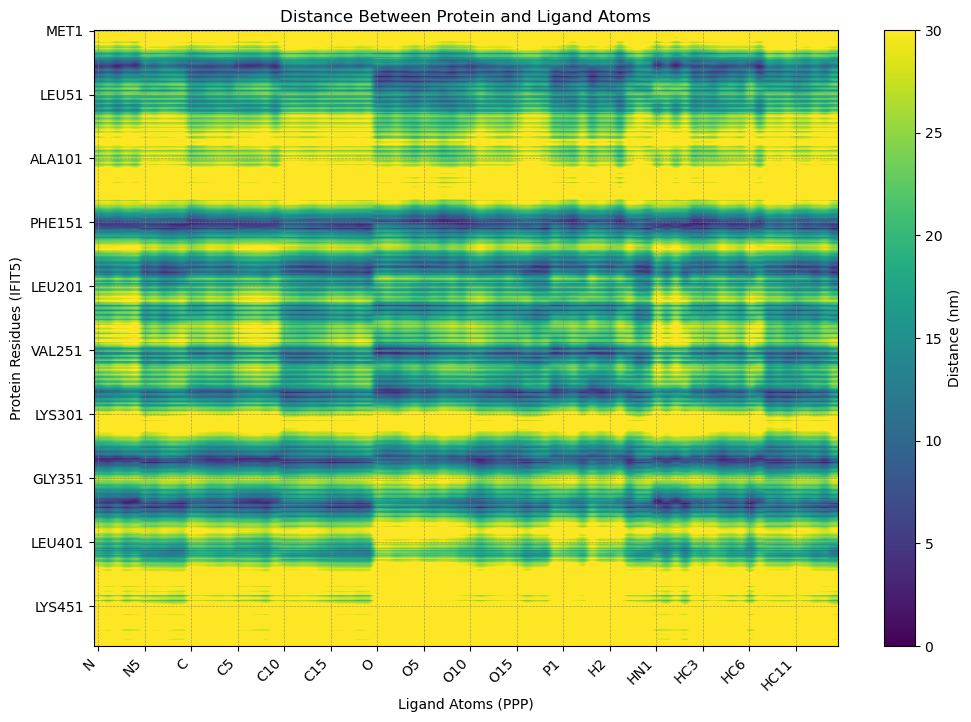

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create the residue-atom distance array with size n for protein and m for ligand, according to ChatGPT (IMPORTANT: THIS CREATES A SORT OF "LANDSCAPE" OF THE INITIAL CONTACTS IN THE MD, PROPMTING WHERE THE MOST PERSISTENT ONES COULD BE)
residue_distances = np.zeros((n_protein, m_ligand))
for i, res in enumerate(protein.residues): #for each residue...
    dist_matrix = distances.distance_array(res.atoms.positions, ligand.positions, box=u.dimensions) #generates a matrix containing protein by ligand positions
    residue_distances[i, :] = dist_matrix.min(axis=0) #generates a matrix that counts the distance between atoms
    
# Define tick intervals (so it is readable, it may be adjusted for larger o smaller proteins/ligands)
tick_interval_protein = 50  
tick_interval_ligand = 5

# Extract labels
protein_labels = [f"{res.resname}{res.resid}" for res in protein.residues][::tick_interval_protein] #for protein
ligand_labels = [atom.name for atom in ligand][::tick_interval_ligand] #for ligand

# Plot the distance matrix (adjust figure size depending on the protein and ligand sizes)
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(residue_distances, origin="upper", cmap="viridis", aspect="auto", vmin=0, vmax=30)

# Set tick labels (from protein and ligand labels already generated) according to documentation (https://userguide.mdanalysis.org/stable/examples/analysis/distances_and_contacts/distances_between_selections.html)
ax.set_yticks(np.arange(n_protein)[::tick_interval_protein]) #array that extracts residues counted in the interval
ax.set_yticklabels(protein_labels) #adds the labels for each interval
ax.set_xticks(np.arange(m_ligand)[::tick_interval_ligand]) #array that extracts ligand counted atoms in the interval
ax.set_xticklabels(ligand_labels, rotation=45, ha="right") #adds the labels slightly tilted to the right so they fit accordingly

# Add labels and titles
plt.ylabel("Protein Residues (protein_name)") #adds y axis label to the plot
plt.xlabel("Ligand Atoms (ligand)") #adds x axis label to the plot
plt.title("Distance Between Protein and Ligand Atoms") #adds title to the plot

# Add gridlines to plot
ax.grid(which="major", axis="both", color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label("Distance (nm)")

# Show the plot and save it
plt.show()
plt.savefig(".png", dpi=300)

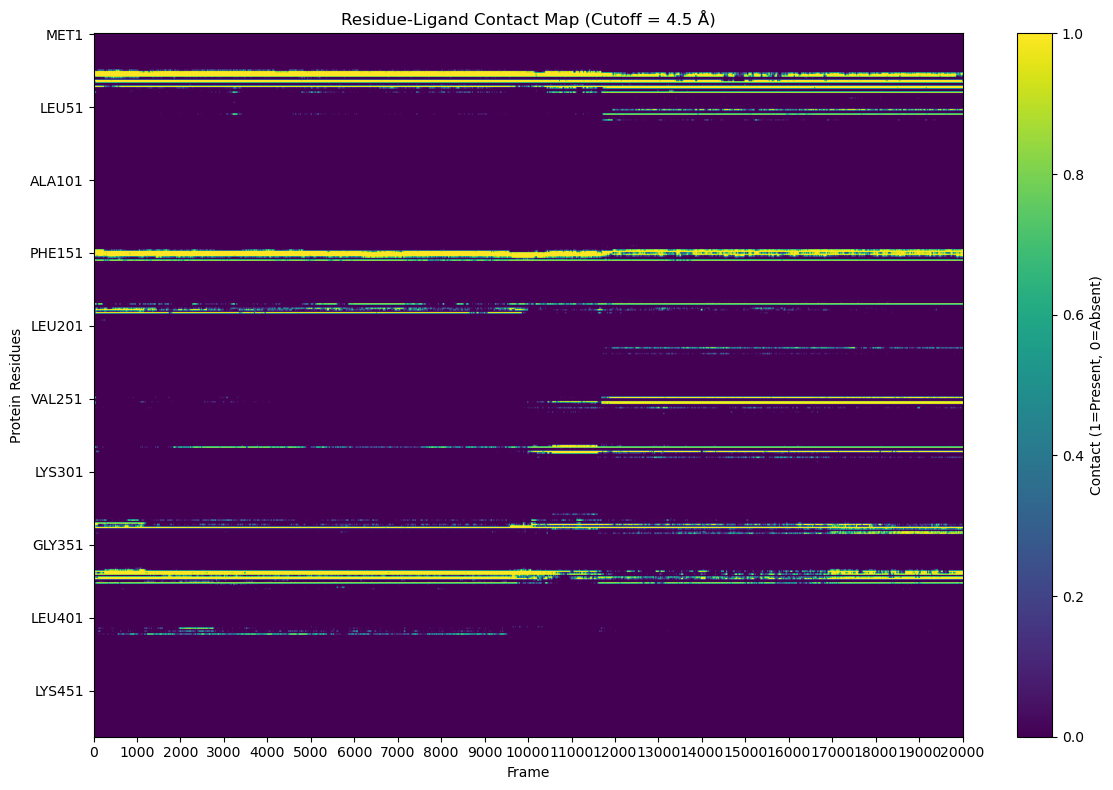

In [ ]:
#Persistent contacts throughout the MD simulation (heatmap) according to https://userguide.mdanalysis.org/stable/examples/analysis/distances_and_contacts/contacts_within_cutoff.html
# Function to calculate a residue-ligand contact matrix, since contacts are considered to exist in 4 or less Amstrongs according to: https://pmc.ncbi.nlm.nih.gov/articles/PMC5708362/, optimized by ChatGPT
def residue_ligand_contact_map(u, protein, ligand, cutoff=4.5):
    n_residues = len(protein.residues)
    n_frames = len(u.trajectory)
    contact_matrix = np.zeros((n_residues, n_frames), dtype=int)
    #This for cycle is specified in the documentation cited above, chatGPT added the trajectory enumeration before the residues'
    for f, ts in enumerate(u.trajectory): #for each enumerated frame...
        for i, residue in enumerate(protein.residues): #for each enumerated residue
            # Calculate the distances for residue atoms to ligand atoms
            dist = contacts.distance_array(residue.atoms.positions, ligand.positions, box=u.dimensions)
            # If any atom is within the cutoff, mark as a contact (which is equal to 1 in the matrix formed by each count in f)
            if np.any(dist < cutoff):
                contact_matrix[i, f] = 1
    return contact_matrix #will output the contact matrix

# Calculate the contact matrix with a cutoff
cutoff = 4.5  # Cutoff distance in Å
contact_matrix = residue_ligand_contact_map(u, protein, ligand, cutoff=cutoff) 

# Plot the contact map
fig, ax = plt.subplots(figsize=(12, 8)) #this will create the fig object and the ax object for the axis (plt.sublplots creates the figure and subplots the axes)
im = ax.imshow(contact_matrix, aspect='auto', cmap='viridis', origin='upper') #Generates the heatmap with contact_matrix, aspect adjusts the figure, cmap uses specific colors for the viridis gradient, origin sets the plot to the upper left corner)

# Add labels
tick_interval_residues = 50  #display the residues in a 50 residues interval
tick_interval_frames = 1000 #display the frames in a 1000 interval
ax.set_yticks(np.arange(len(protein.residues))[::tick_interval_residues]) #generates an array with the residues in the interval
ax.set_yticklabels([f"{res.resname}{res.resid}" for res in protein.residues][::tick_interval_residues]) #adds labels for each residue in the interval
ax.set_xticks(np.arange(contact_matrix.shape[1])[::tick_interval_frames]) #generates an array with the frames in the interval
ax.set_xticklabels(np.arange(contact_matrix.shape[1])[::tick_interval_frames]) #adds labels for each frame in the interval

# Add titles and labels for the plot
plt.xlabel('Frame')
plt.ylabel('Protein Residues')
plt.title(f'Residue-Ligand Contact Map (Cutoff = {cutoff} Å)')

# Add colorbar, label and save
cbar = plt.colorbar(im)
cbar.set_label('Contact (1=Present, 0=Absent)')
plt.tight_layout()
plt.savefig(".png")
plt.show()

    Residue  Contact Fraction
338  PHE339          0.999250
33    VAL34          0.999050
36    THR37          0.974751
151  GLY152          0.972651
155  TYR156          0.959202
..      ...               ...
172  ASN173          0.000000
171  ASP172          0.000000
170  PRO171          0.000000
169  GLU170          0.000000
481  ILE482          0.000000

[482 rows x 2 columns]


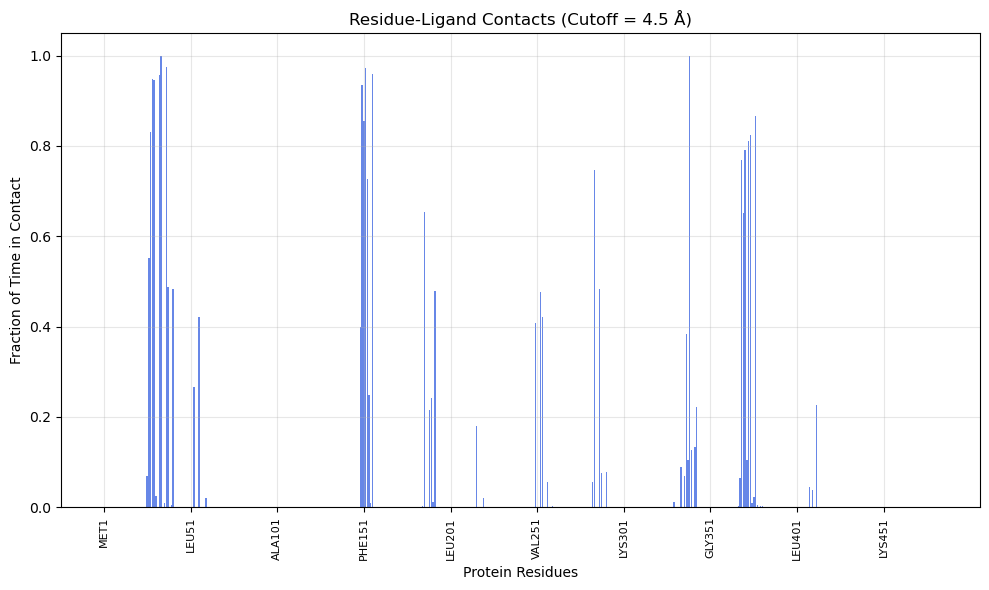

In [ ]:
#Bar plot for persistence in contacts, according to https://userguide.mdanalysis.org/stable/examples/analysis/distances_and_contacts/contacts_within_cutoff.html with ChatGPT's modifications
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import contacts

# Function to calculate residue-level contacts within a cutoff in time fractions
def residue_contacts_within_cutoff(u, protein, ligand, cutoff=4.5):
    n_residues = len(protein.residues) #numbering the residues in the protein
    n_frames = len(u.trajectory) #numbering the frames
    residue_contacts = np.zeros((n_residues, n_frames), dtype=int)  # Array to store Rows: residues, Columns: frames
    
    for f, ts in enumerate(u.trajectory): #for each frame...
        for i, residue in enumerate(protein.residues): #for each residue in the protein...
            dist = contacts.distance_array(residue.atoms.positions, ligand.positions, box=u.dimensions) # Calculate distances for residue atoms to ligand atoms
            # If any atom in the residue is within the cutoff, increment the contact count
            if np.any(dist < cutoff):
                residue_contacts[i, f] = 1  # Mark residue as in contact=1 for each frame of the f object
    return residue_contacts

# Calculate residue-level contact matrix
cutoff = 4.5  # Distance cutoff in Å
residue_contact_matrix = residue_contacts_within_cutoff(u, protein, ligand, cutoff=cutoff)

# Sum contacts over the trajectory
residue_contact_sums = residue_contact_matrix.sum(axis=1)  

# Normalize to fraction of frames where contact occurs (that is, each sum by the residue matrix size, which is the entire trajectory frames)
residue_contact_fractions = residue_contact_sums / residue_contact_matrix.shape[1]

# Create a DataFrame for easy visualization, generates a df in which residues are accomodated by contact fractions
residue_df = pd.DataFrame({
    "Residue": [f"{res.resname}{res.resid}" for res in protein.residues],
    "Contact Fraction": residue_contact_fractions
})

# Sort by most persistent contacts
residue_df_sorted = residue_df.sort_values(by="Contact Fraction", ascending=False) #sorts the residues by ascending order with the most persistent contacts

# Print the DataFrame
print(residue_df_sorted)

# Save in CSV file
residue_df_sorted.to_csv("residue_contacts.csv", index=False)

# Plot the residue-level contact fractions with interval labels and positions relative to them
tick_interval= 50
tick_positions = np.arange(0, len(residue_df), tick_interval)
tick_labels = residue_df["Residue"].iloc[tick_positions]

# Plot the residue-level contact fractions in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(residue_df)), residue_df["Contact Fraction"], color="royalblue", alpha=0.8)
plt.xlabel("Protein Residues")
plt.ylabel("Fraction of Time in Contact")
plt.title(f"Residue-Ligand Contacts (Cutoff = {cutoff} Å)")

# Set the tick positions and labels
plt.xticks(tick_positions, tick_labels, rotation=90, fontsize=8)

plt.tight_layout()
plt.grid(alpha=0.3)
plt.savefig(".png")
plt.show()

     Range  Count
0    1-0.9      9
1  0.9-0.8      5
2  0.8-0.7      4
3  0.7-0.6      2
4  0.6-0.5      1
5  0.5-0.4      8
6  0.4-0.3      2
7  0.3-0.2      6
8  0.2-0.1      5


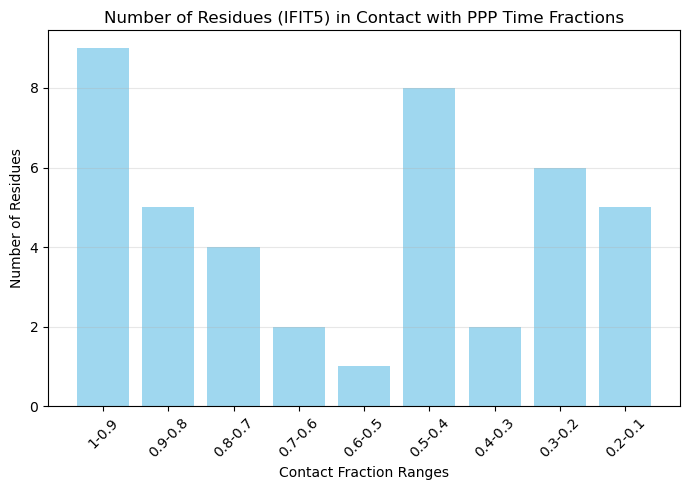

In [ ]:
#Counting which and how many residues are there in each fraction of time (Optimized by ChatGPT from original code)
import pandas as pd
df=pd.read_csv("residue_contacts.csv")

#Define ranges
ranges = [(1, 0.9), (0.9, 0.8), (0.8, 0.7), (0.7, 0.6), (0.6, 0.5), (0.5, 0.4), (0.4, 0.3), (0.3, 0.2), (0.2, 0.1)]

#Create a list to store the results
counts = []

#Loop through the ranges and calculate counts
for upper, lower in ranges:
    filtered_df = df[(df['Contact Fraction'] <= upper) & (df['Contact Fraction'] > lower)]
    count = len(filtered_df)
    counts.append((f"{upper}-{lower}", count))

# Convert the results into a DataFrame
counts_df = pd.DataFrame(counts, columns=["Range", "Count"])

# Print the result
print(counts_df)

# Plot the counts
plt.figure(figsize=(7, 5))
plt.bar(counts_df["Range"], counts_df["Count"], color="skyblue", alpha=0.8)
plt.xlabel("Contact Fraction Ranges")
plt.ylabel("Number of Residues")
plt.title("Number of Residues (protein_name) in Contact with ligand Time Fractions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y", alpha=0.3)
plt.savefig(".png")
plt.show()

In [ ]:
#H-bonds between protein and ligand analysis, according to Paul Smith, 2019: https://docs.mdanalysis.org/1.1.0/documentation_pages/analysis/hydrogenbonds.html and chatgpt modifications

In [ ]:
import MDAnalysis as mda
import pandas as pd
import MDAnalysis
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

#Will use the same u variable for the Universe, and the .tpr file which includes the ligand's topology (charges and masses), as well as the trajetory file
hbonds = HBA(universe= u,
            donors_sel = 'resname ligand and name H* or protein and name H*', #This makes sure that either ligand or protein are considered as donors
            acceptors_sel = 'resname ligand and (name O* or name N*) or protein and (name O* or name N*)', #This makes sure that either ligand or protein are considered as acceptors
            hydrogens_sel = 'name H*',
            d_h_cutoff= 1.2, # Distance cutoff used for finding donor-hydrogen pairs
            d_a_cutoff = 3.0, # Distance cutoff for hydrogen bonds (this cutoff refers to the Donor-Acceptor distance)
            d_h_a_angle_cutoff = 150 #Minimum angle of H-bond formation, usually ranges from 170-180 degrees, but weaks H-bonds can be angled up to 150 degrees
            )

In [119]:
#Running the analysis
hbonds.run()

In [120]:
# Extract raw hydrogen bond data which contains all H-bonds formed throughout the trajectory (which will later be filtered by only ligand-protein interactions)
hbonds_data = hbonds.results.hbonds
hbonds_df = pd.DataFrame(hbonds_data, columns=['Frame', 'Donor_ID', 'Hydrogen_ID', 'Acceptor_ID', 'Distance', 'Angle'])

# Function to extract residue names (to know which residues are forming h-bonds)
def get_resname(atom_id): #function that retrieves atoms' ID's from residues's names
    try:
        atom_id = int(atom_id) #each ID is converted into an integer
        if 0 <= atom_id < len(u.atoms): #checks whether the ID is within the universe's (u) atoms
            return u.atoms[atom_id].residue.resname #outputs the residue name
        else:
            return "UNKNOWN" #if it isn't within the u, it will return unknown, which could be useful for checking odd rows
    except:
        return "UNKNOWN"

In [121]:
# Applying the function to donor and acceptor columns to the Donor_ID and Acceptor_ID columns
hbonds_df["Donor_Resname"] = hbonds_df["Donor_ID"].apply(get_resname)
hbonds_df["Acceptor_Resname"] = hbonds_df["Acceptor_ID"].apply(get_resname)

#Checking the hbonds_df
hbonds_df

,Frame,Donor_ID,Hydrogen_ID,Acceptor_ID,Distance,Angle,Donor_Resname,Acceptor_Resname
0,0.0,1.0,1.0,0.0,1.011192,180.0,MET,MET
1,0.0,22.0,22.0,19.0,2.027442,180.0,SER,SER
2,0.0,22.0,22.0,18.0,2.367805,180.0,SER,MET
3,0.0,25.0,25.0,26.0,2.105833,180.0,SER,SER
4,0.0,31.0,31.0,30.0,1.007423,180.0,GLU,GLU
...,...,...,...,...,...,...,...,...
17420262,20000.0,7927.0,7927.0,7863.0,2.644882,180.0,PPP,PPP
17420263,20000.0,7930.0,7930.0,2541.0,2.964001,180.0,PPP,TYR
17420264,20000.0,7933.0,7933.0,7864.0,2.123707,180.0,PPP,PPP
17420265,20000.0,7938.0,7938.0,7910.0,2.012261,180.0,PPP,PPP


In [ ]:
# Filtering only ligand-protein interactions (because the counts made by MDAnalysis consider also inter-protein and inter-ligand h-bonds)
ligand_resname = "ligand"
filtered_hbonds_df = hbonds_df[
    ((hbonds_df["Donor_Resname"] == ligand_resname) & (hbonds_df["Acceptor_Resname"] != ligand_resname)) | #checks whether the ligand is the donor and the protein the acceptor
    ((hbonds_df["Donor_Resname"] != ligand_resname) & (hbonds_df["Acceptor_Resname"] == ligand_resname)) #the function OR (|) passes this info to the next condition which checks whether the protein is the donor and the ligand the acceptor 
]

#Checking the filtered_hbonds_df (should significantly lower the # of rows)
filtered_hbonds_df

,Frame,Donor_ID,Hydrogen_ID,Acceptor_ID,Distance,Angle,Donor_Resname,Acceptor_Resname
650,0.0,5993.0,5993.0,7866.0,2.457107,180.0,ILE,PPP
1522,1.0,5993.0,5993.0,7867.0,2.608570,180.0,ILE,PPP
1523,1.0,5993.0,5993.0,7866.0,2.847266,180.0,ILE,PPP
1526,1.0,6018.0,6018.0,7872.0,2.697662,180.0,THR,PPP
2380,2.0,6016.0,6016.0,7872.0,2.953206,180.0,THR,PPP
...,...,...,...,...,...,...,...,...
17419484,20000.0,613.0,613.0,7866.0,2.736076,180.0,THR,PPP
17419485,20000.0,633.0,633.0,7867.0,2.822415,180.0,ILE,PPP
17419992,20000.0,5522.0,5522.0,7911.0,2.780826,180.0,PHE,PPP
17420263,20000.0,7930.0,7930.0,2541.0,2.964001,180.0,PPP,TYR


In [123]:
# Counting ligand-protein hydrogen bonds per frame
filtered_hbond_counts = filtered_hbonds_df.groupby("Frame").size().reset_index(name="H-bond Count")
# NOTE: we can't rely on the count_by_time() function from MDAnalysis because it considers the entire h-bonds formed intra-protein and intra-ligand

In [ ]:
# Filling for missing frames (with 0 H-bonds), because MDAnalysis does not take into account frames with 0 h-bonds
all_frames = np.arange(filtered_hbond_counts["Frame"].min(), filtered_hbond_counts["Frame"].max() + 1) #this makes an array which fills in the missing frames with the missing frame number
filtered_hbond_counts = filtered_hbond_counts.set_index("Frame").reindex(all_frames, fill_value=0).reset_index() #this will assign each missing frame a 0 H-bond value

# Saving filtered results (remember to check them before plotting)
filtered_hbond_counts.to_csv("filtered_hbond_count_by_frame.csv", index=False)

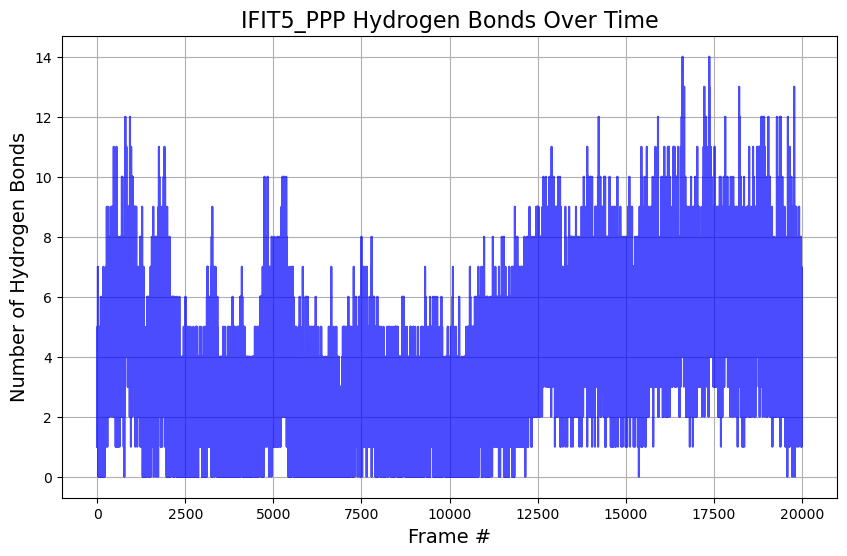

In [ ]:
# Plot ligand-protein H-bonds over time
plt.figure(figsize=(10, 6))
plt.plot(filtered_hbond_counts["Frame"], filtered_hbond_counts["H-bond Count"], linestyle='-', color='b', alpha=0.7)
plt.title("protein_ligand Hydrogen Bonds Over Time", fontsize=16)
plt.xlabel("Frame #", fontsize=14)
plt.ylabel("Number of Hydrogen Bonds", fontsize=14)
plt.grid(True)
plt.savefig(".png", dpi=300)
plt.show()